In [36]:
import bclr
import ruptures as rpt
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

Multiple changepoint demo

In [154]:
n, dim = 500, 3  # number of samples, dimension
n_bkps, sigma = 5, 5  # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
prior_cov=np.diag(np.repeat(2, 3))
bclrM = bclr.MultiBayesCC(signal, cps=5, prior_cov=prior_cov, n_iter=1000)
bclrM.warm_up()

In [155]:
print(bkps[:-1])

[78, 162, 244, 330, 410]


In [156]:
bclrM.fit()

In [157]:
bclrM.transform()
bclrM.cps_df()

,Location,Posterior Probability,Normalized Entropy
0,77.0,0.502,0.178276
1,162.0,0.820,0.113151
2,244.0,0.562,0.214272
3,330.0,0.858,0.090615
4,410.0,0.910,0.065865


### Correctly identifies the changes in each coordinate!!!

In [41]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([0.902, 0.   , 0.688]),
 array([0.006, 0.   , 0.   ]),
 array([1., 0., 0.]),
 array([0.014, 1.   , 1.   ]),
 array([0.   , 0.912, 0.994])]

In [42]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([ 0.27276967, -2.00562572,  0.11146181]),
 array([-0.56744372, -1.01239823, -1.92697498]),
 array([ 1.19327988, -0.86756685, -0.73316486]),
 array([-0.56224718,  1.42155512,  2.741621  ]),
 array([-1.15501495,  0.24975092,  0.45978154])]

In [43]:
bkps2 = [0]+bkps
for i in range(len(bkps2)-1):
    print(np.mean(signal[bkps2[i]:bkps2[i+1], :], axis=0))

[ 4.83047158  7.26485151 -6.23931886]
[ 5.97121309  0.45645629 -5.78142036]
[  2.76049924  -4.32712743 -14.59813741]
[  7.86301066  -8.67928694 -17.96562553]
[ 3.02280716 -2.27660267 -6.64197636]
[-2.03346246 -0.48215555 -4.25718657]


In [44]:
kern_cpd = rpt.KernelCPD(kernel='rbf')
kern_cpd.fit_predict(signal, n_bkps=5)[:-1]

[76, 168, 256, 331, 420]

## What if we looked at changes of differing nature?

In [45]:
np.random.seed(881923)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)

a = np.random.randn(100, 3) @ L1
b = np.random.randn(75, 3) @ L2
c = np.random.randn(30, 3) @ L2 + np.broadcast_to([0, 3, -1], (30, 3))

Xnew = pf.fit_transform(ss.fit_transform(np.r_[a,b,c]))

In [46]:
prior_cov9 = np.diag(np.repeat(1, 9))

In [47]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=2, prior_cov=prior_cov9, n_iter=1000)
bclrM_new.warm_up()
bclrM_new.fit()

In [48]:
bclrM_new.transform()
bclrM_new.cps_df()

,Location,Posterior Probability,Normalized Entropy
0,103.0,0.418,0.336200
1,175.0,0.902,0.080606


### Now we can summarize the output of our algorithm...

In [49]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.454, 0.52 , 0.47 , 1.   , 0.7  , 0.564, 0.828, 0.55 , 0.7  ]),
 array([0.454, 1.   , 0.266, 0.342, 0.274, 0.168, 1.   , 0.106, 0.05 ])]

In [50]:
# This indciates that the x_1^2 increases the most in the first instance, 
# and x_2 for the second changepoint, thought x_2^2 is close...
[bc.post_beta_mean for bc in bclrM_new.bccs_]

[array([-0.0449274 , -0.00211459, -0.01458874,  1.81707195,  0.15848332,
         0.04631313,  0.22787763,  0.0265872 ,  0.09984628]),
 array([-0.07402005,  2.74152762, -0.27156742, -0.20405605, -0.33048747,
        -0.42222266,  2.63714952, -0.70233848, -0.7725654 ])]

In [51]:
# Usual rbf kernel with dynamic programming to find the changes...
kern_cpd.fit_predict(Xnew, n_bkps = 2)[:-1]

[103, 175]

In [52]:
changeforest.changeforest(Xnew).split_points()

[103, 175]

### Central England temperature series

In [53]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [54]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])

In [158]:
cps = list(np.array([1700, 1738, 1988])-1658)

In [159]:
prior_cov1 = np.diag(np.repeat(10,1))
ncps = 3
bclrM_cet = bclr.MultiBayesCC(Xcet, cps=ncps, prior_cov=prior_cov1, 
                              n_iter=1000, lam=0) #try also 9 changepoints to see what we find...
bclrM_cet.warm_up(random_init=True, reps=20)

In [160]:
print(bclrM_cet.bkps)
bclrM_cet.prior_cov = np.diag(np.repeat(1,1))
bclrM_cet.lam = 0
bclrM_cet.fit()

[0, 52, 267, 330, 365]


In [161]:
bclrM_cet.transform()
df_dis = bclrM_cet.cps_df(1658)
print(df_dis.sort_values(by=['Normalized Entropy']))

   Location  Posterior Probability  Normalized Entropy
2    1988.0                  0.380            0.350648
0    1705.0                  0.092            0.635837
1    1892.0                  0.076            0.678966


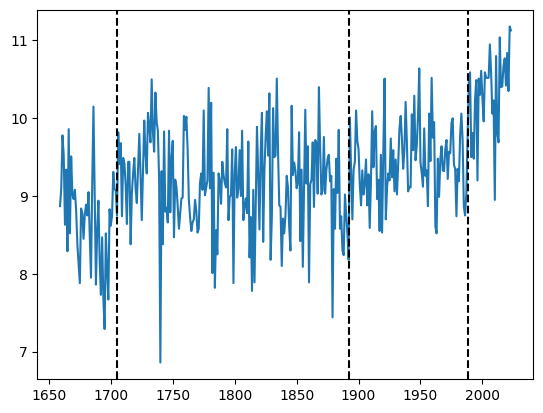

In [162]:
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)
plt.plot(years[:], Xcet[:])
[plt.axvline(df_dis['Location'][i], color='black', linestyle='--') for i in range(3)]

In [140]:
np.array(kern_cpd.fit_predict(Xcet, n_bkps = 3)[:-1])+1658

array([1701, 1910, 1987])

In [141]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])